## Imports
Largely based on deepsort+yolov7 [github repo](https://github.com/deshwalmahesh/yolov7-deepsort-tracking)

We have 3 important files for this purpose and each and every dependency, class, import, function, variable etc is being imported from these modules

1. `detection_helpers` Made to wrap the original `YOLOv-7` code along with helper functions
2. `tracking_helpers2` has modular code which is used to wrap the `DeepSORT` repo and workings
3. `bridge_wrapper2` acts as a bridge to bind any detection model with `DeepSORT`. Modified from the original for extra functionality. The original class was not touched, but a subclass was added: `YoloDeepsortUtility`

In [ ]:
from detection_helpers import *
from tracking_helpers2 import *
from  bridge_wrapper2 import YoloDeepsortUtility, TRACKER_PARAMS
from PIL import Image
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Detection
Detect objects using `Yolov-7`

In [ ]:
detector = Detector(classes = [0,1], conf_thres = TRACKER_PARAMS["conf_thres"], iou_thresh=TRACKER_PARAMS["iou_thresh"]) # class = None means detect all classes. List info at: "data/coco.yaml"
# conf 45 is alright
detector.load_model(TRACKER_PARAMS["model_path"],img_size=TRACKER_PARAMS["img_size"]) # pass the path to the trained weight file

d:\Proyectos\HAU\codigo\3-path-planning\yolov7_deepsort_tracking\models\experimental.py:88: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(w, map_location=m

Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
 Convert model to Traced-model... 


KeyboardInterrupt: 

Check if video card is being used. If False, go through the torch+cuda installation described in `README.md`

In [11]:
import torch
print(torch.cuda.is_available())

True


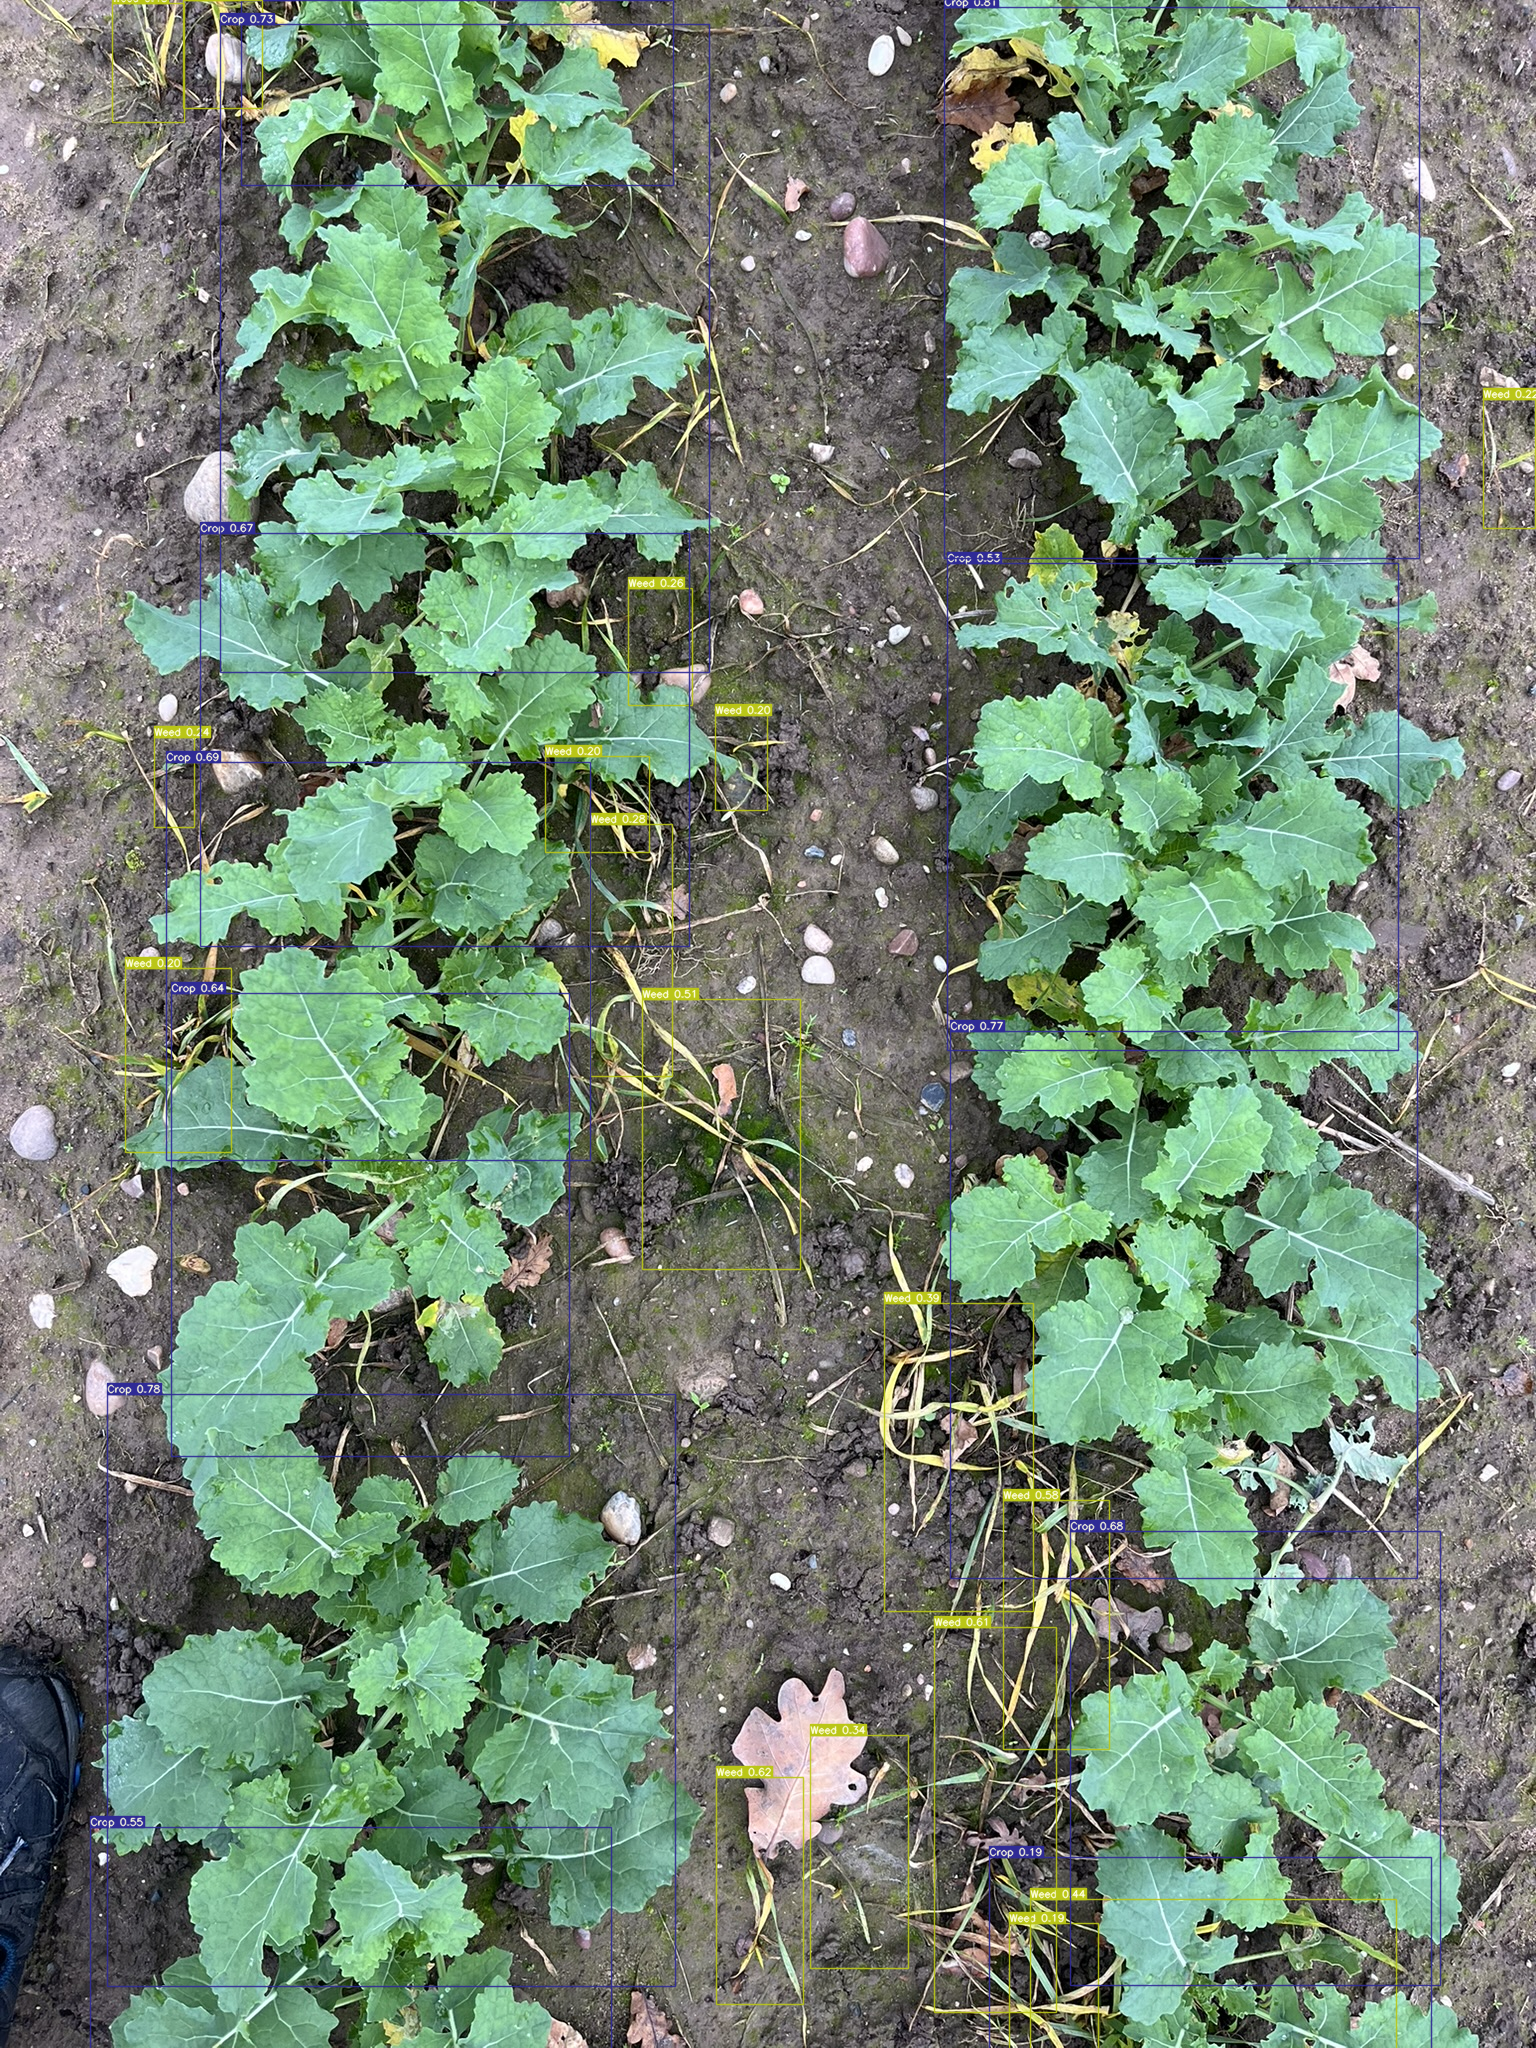

In [5]:
# Pass in any image path or Numpy Image using 'BGR' format
result = detector.detect('./IO_data/input/images/plants.JPEG', plot_bb = True) # plot_bb = False output the predictions as [x,y,w,h, confidence, class]


if len(result.shape) == 3:# If it is image, convert it to proper image. detector will give "BGR" image
    result = Image.fromarray(cv2.cvtColor(result,cv2.COLOR_BGR2RGB)) 
    
result

# Tracking

Works as follows:
1. Read each frame of video using `OpenCV`
2. Get Bounding Box or Detections from the model per frame
3. Crop those patches and pass on to `reID` model for re identification which is a part of `DeepSORT` method
4. Get the above embeddings and then use `Kalman Filtering` and `Hungerian assignment` to assign the correct BB to the respective object
5. Show, Save the frames

In [12]:
PARAMS = {"conf":0.35,
          "iou_thresh": 0.45,
          "img_size": 1088,
          "max_iou_distance": 0.4, # objects may be considered the same if within this distance
          "max_age": 20, # Frames of failed detection before tracking stops
          "n_init": 1, # Number of frames to initialize tracker for an object
          }

In [30]:

detector = Detector(classes = [0,1], conf_thres = TRACKER_PARAMS["conf_thres"], iou_thresh=TRACKER_PARAMS["iou_thresh"]) # class = None means detect all classes. List info at: "data/coco.yaml"
# conf 45 is alright
detector.load_model(TRACKER_PARAMS["model_path"],img_size=TRACKER_PARAMS["img_size"]) # pass the path to the trained weight file

d:\Proyectos\HAU\codigo\3-path-planning\yolov7_deepsort_tracking\models\experimental.py:88: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(w, map_location=m

Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
 Convert model to Traced-model... 
 traced_script_module saved! 
 model is traced! 



In [ ]:
# Initialise  class that binds detector and tracker in one class
tracker = YoloDeepsortUtility(detector=detector,params_dict=TRACKER_PARAMS)

# tracker = JustYoloUtility(detector) #Object detection without tracking
tracker.satturation = 2 # satturation increase. doesn't seem to affect much
tracker.rotate = True
tracker.frames_to_treat = 15
tracker.max_trace_length = 20 # default 15
tracker.draw_object_detections = False
# output = None will not save the output video ;; "./IO_data/output/vid3-s-tracked-B.avi"
# 
tracker.track_video("./IO_data/input/video/vid3-shortened.mp4", output=None, show_live = True, skip_frames = 0, verbose=1,
                    frame_start=160, count_objects=True) #674 pretty good examples
# problem crop at 1120. Solved with 55% conf. problem at 2300? solved iwth max_iou_distance=0.2 
# Some weeds identified as crops(near 600) were solved by reducing maxi distance to 0.4
# some missed tiny weeds at 1400? and 1800. Solved by bypassing a confirmation check. They are jittery though. Try adjusting max iou distance and max cosine distance
# Also try with another deepsort weights model?

nn_budget not in params_dict. Using default
Frame: 160 || Current FPS: 1.12 || 4 objects on screen: []
Frame: 161 || Current FPS: 17.44 || 4 objects on screen: ['crop1', 'crop2', 'crop3', 'crop4']
Frame: 162 || Current FPS: 18.68 || 4 objects on screen: ['crop1', 'crop2', 'crop3', 'crop4']
Frame: 163 || Current FPS: 16.2 || 4 objects on screen: ['crop1', 'crop2', 'crop3', 'crop4']
Frame: 164 || Current FPS: 17.16 || 4 objects on screen: ['crop1', 'crop2', 'crop3', 'crop4']
Frame: 165 || Current FPS: 15.53 || 4 objects on screen: ['crop1', 'crop2', 'crop3', 'crop4']
Frame: 166 || Current FPS: 15.4 || 4 objects on screen: ['crop1', 'crop2', 'crop3', 'crop4']
Frame: 167 || Current FPS: 18.63 || 4 objects on screen: ['crop1', 'crop2', 'crop3', 'crop4']
Frame: 168 || Current FPS: 18.18 || 4 objects on screen: ['crop1', 'crop2', 'crop3', 'crop4']
Frame: 169 || Current FPS: 16.53 || 5 objects on screen: ['crop1', 'crop2', 'crop3', 'crop4']
Frame: 170 || Current FPS: 12.7 || 5 objects on scree